<a href="https://www.nvidia.com/dli"> <img src="images/DLI Header.png" alt="Header" style="width: 400px;"/> </a>

# 이미지 자막 생성(Image Captioning)

이번 실습에서는 딥 러닝의 워크플로우들을 결합하여, 인공지능 (AI)으로 각 장면의 설명을 생성해보겠습니다. MSCO(Microsoft Common Object in Context) 데이터셋은 여러 개의 이미지와 각 이미지에 대한 5개 이상의 자막으로 구성되어 있습니다. 따라서 우리는 지도학습을 위해 입력(input)과 그에 상응하는 출력(output), 두 개의 필수 학습 요소를 가지고 있는 것입니다. 이번 과제는 시각적 또는 언어 기반 데이터 모두에 적합한 네트워크와 워크플로우를 식별하는 것이 될 것입니다.

우리는 이미지 분류를 통해 이미지에 대한 높은 수준의 이해가 가능하게 하는 법을 배웠습니다. 자연어 처리의 기본을 통해, 우리는 순환 신경망 (RNNs)을 사용하여 문맥(context)으로부터 문장(text)를 생성해 내는 법을 배웠습니다. 이 실습에서는 RNN이 언어 예측치를 생성하기 위해 사용하는 RNN에 우리의 높은 수준의 이미지 인식 및 상황 인식기법을 추가하는 것을 배우게 될 것입니다. 

먼저 모듈을 가져오는 것으로 시작합시다.

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import inspect
import time

import numpy as np
import tensorflow as tf
from tensorflow.python.framework import ops
from tensorflow.python.framework import dtypes
#import reader
import collections
import os
import re
import json

import matplotlib.pyplot as plt

from scipy import ndimage
from scipy import misc
import sys
sys.path.insert(0, '/dli/data/mdt/models/slim')

slim=tf.contrib.slim
from nets import vgg

from preprocessing import vgg_preprocessing

%matplotlib inline  
!nvidia-smi

Mon Feb 24 12:38:04 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 396.26                 Driver Version: 396.26                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:1E.0 Off |                    0 |
| N/A   47C    P0    66W / 149W |      0MiB / 11441MiB |     97%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

### 픽셀과 컨텍스트 연결하기

먼저 이미지 분류 워크플로우를 수정하여 단순한 레이블 이상의 정보를 갖는 이미지에 대한 높은 수준의 이해가 가능하도록 하는 방법을 살펴보겠습니다.

분류문제에서 수상을 한 VGG 네트워크를 이용하여 MSCOCO 영상들을 입력으로 넣어줄 겁니다. VGG의 "`softmax`" 나 마지막 layer인 마지막 출력 layer를 확인해 보는 대신, 우리는 그 바로 이전 단계인 `fc7`의 [feature vector](#fv "An array midway through the neural network that represents some features of the input")를 확인해 볼 것 예정입니다.

In [2]:
TRAIN_IMAGE_PATH='/dli/data/mdt/mscoco/train2014/'
## Read Training files
with open("/dli/data/mdt/mscoco/captions_train2014.json") as data_file:
         data=json.load(data_file)

image_feature_vectors={}   
tf.reset_default_graph()
    
one_image=ndimage.imread(TRAIN_IMAGE_PATH+data["images"][0]['file_name'])
    #resize for vgg network
resize_img=misc.imresize(one_image,[224,224])
if len(one_image.shape)!= 3: #Check to see if the image is grayscale if True mirror colorband
    resize_img=np.asarray(np.dstack((resize_img, resize_img, resize_img)), dtype=np.uint8)

processed_image = vgg_preprocessing.preprocess_image(resize_img, 224, 224, is_training=False)
processed_images  = tf.expand_dims(processed_image, 0)      
network,endpts= vgg.vgg_16(processed_images, is_training=False)

   
init_fn = slim.assign_from_checkpoint_fn(os.path.join('/dli/data/mdt/mscoco/vgg_16.ckpt'),slim.get_model_variables('vgg_16'))
sess = tf.Session()
init_fn(sess)
NETWORK,ENDPTS=sess.run([network,endpts])
sess.close()
print('fc7 array for a single image')
print(ENDPTS['vgg_16/fc7'][0][0][0])  

INFO:tensorflow:Restoring parameters from /dli/data/mdt/mscoco/vgg_16.ckpt
fc7 array for a single image
[0.81308055 2.55591    0.9547044  ... 1.5095446  0.         0.        ]


여기 많은 정보가 있는 것이 분명해 보이지요? 무엇이 "..." 안에 들어있는지 vector를 plot으로 시각화 하여 알아봅시다.

u'COCO_train2014_000000057870.jpg'

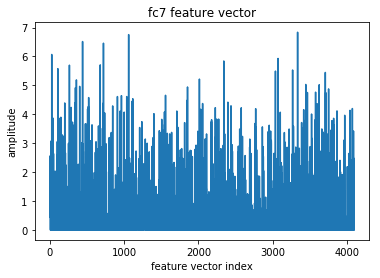

In [3]:
plt.plot(ENDPTS['vgg_16/fc7'][0][0][0])
plt.xlabel('feature vector index')
plt.ylabel('amplitude')
plt.title('fc7 feature vector')
data["images"][0]['file_name']

여기 보시는 것은 다양한 진폭의 4000개 이상의 파라미터입니다. 일반적으로 CNN(Convolution Neural Network)의 마지막 layer에서는 "cat" 또는 "dog"와 같이 단순한 레이블값이 되도록 구성되어 있습니다. 하지만, 분명한 것은 모든 이미지에 이미 포함된 주요 개체보다 더 많은 것이 있다는 것입니다.

- 어떤 종류의 고양이?
- 무엇을 하고 있는가?
- 다른 중요한 사실은?
- 등등

이미지가 서로 비슷할수록 featur vector는 더 유사할 것이라고 상상할 수 있습니다. 따라서 우리는 이 vector를 자막 생성을 위한 "context"로 사용할 것입니다.
그렇게 하기 전에 아래 코드 블록을 사용하여 네트워크에서 서로 다른 계층의 결과들을 살펴보십시오. 

첫 번째 convolutional layer에서 feature map을 어떻게 볼 수 있습니까? 힌트가 필요하시면 [여기](#정답1 "Convolutional layer의 output은 height, width 그리고 the number of feature maps의 형태로 이루어져있다. FEATUREMAPID는 0과 (the number of feature maps - 1)사이의 값을 갖는다.")에 마우스를 올리세요.

```
Convolutional layer의 output은 height, width 그리고 the number of feature maps의 형태로 이루어져있다. FEATUREMAPID는 0과 (the number of feature maps - 1)사이의 값을 갖는다."
```

(224, 224, 64)
input image and feature map from  vgg_16/conv1/conv1_1


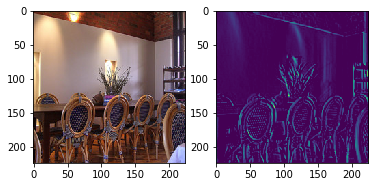

In [4]:
featuremap='vgg_16/conv1/conv1_1'
print(ENDPTS[featuremap][0].shape)
FEATUREMAPID=63
print('input image and feature map from ',featuremap)
plt.subplot(1,2,1)
plt.imshow(resize_img)
plt.subplot(1,2,2)
plt.imshow(ENDPTS[featuremap][0][:,:,FEATUREMAPID])

네트워크에서 서로 다른 레이어의 결과들을 어떻게 확인할 수 있었습니까? 여러분이 할 수 있는지 위의 코드를 실험해 보십시오.

## 이미지 및 자막 조합

### 이미지에서 높은 수준의 feature vector 가져오기

일정시간 동안 VGG를 통해 데이터셋의 각 이미지를 실행하여, feature vector를 numpy (https://www.numpy.org) 파일에 저장했습니다. 이 파일을 가져오십시오.

In [5]:
example_load=np.load('/dli/data/mdt/mscoco/train_vgg_16_fc7_2000.npy').tolist()
image_ids=example_load.keys()
print('Number of images in the training set: ', len(example_load.keys()))

Number of images in the training set:  2000


### 자막을 이미지에 맞추기 (Aligning cations with images)

다음으로, feature map과 각각의 자막을 연관시킬 것입니다. 데이터셋들은 각각 최소 5개의 자막이 있습니다. 아래 코드를 실행하여 한 이미지의 자막을 보십시오.

MSCOCO captions for a single image


[[u'a restaurant has modern wooden tables and chairs.'],
 [u'a long restaurant table with rattan rounded back chairs.'],
 [u'a long table with a plant on top of it surrounded with wooden chairs '],
 [u'a long table with a flower arrangement in the middle for meetings'],
 [u'a table is adorned with wooden chairs with blue accents.']]

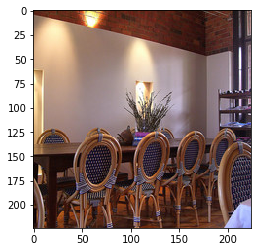

In [6]:
CaptionsForOneImage=[]
for k in range(len(data['annotations'])):
    if data['annotations'][k]['image_id']==data["images"][0]['id']:
        CaptionsForOneImage.append([data['annotations'][k]['caption'].lower()])
plt.imshow(resize_img)
print('MSCOCO captions for a single image')
CaptionsForOneImage

시간 관계상, 2000 개의 [MSCOCO](http://cocodataset.org/#home) 이미지로 특징 벡터를 가진 파일을 미리 만들어 두었습니다. 다음으로, 자막을 로드하고 정렬하십시오. 기다리시는 동안MSCOCO 데이터 세트를 읽어보시기 바랍니다.

In [7]:
#Create 3 lists image_id, feature maps, and captions.
temporary_image_ids = []
temporary_captions = []
annotations = data['annotations']
for k in range(len(annotations)):
    target_image_id = annotations[k]['image_id']
    if target_image_id in image_ids:
        temporary_image_ids.append(target_image_id)
        temporary_captions.append(annotations[k]['caption'])

image_id_key=[]
feature_maps_to_id=[]
caption_to_id=[]
for image_id in image_ids:
    while image_id in temporary_image_ids:
        k = temporary_image_ids.index(image_id)
        temporary_image_ids.remove(image_id)
        caption = temporary_captions.pop(k)

        image_id_key.append([image_id])
        feature_maps_to_id.append(example_load[image_id])
        caption_to_id.append(re.sub('[^A-Za-z0-9]+',' ',caption).lower()) #remove punctuation 

print('number of images ',len(image_ids))
print('number of captions ',len(caption_to_id))

number of images  2000
number of captions  10006


위의 셀에서 image_id, feature map 및 자막에 대한 세 개의 리스트를 생성했습니다. 각 목록들의 값들이 잘 입력되었는지 확인하기 위해 한 영상에 대한 이미지 ID 및 자막을 표시할 수 있습니다.

image_id  [[196611], [196611], [196611], [196611], [196611]]
the captions for this image 
[u'a light turned on at a desk with a chair and computer ', u'a living room with the light on next to a computer desk ', u'a living room with a white chair and desk ', u'a computer on a desk next to an empty chair ', u'empty chair in front of a desk with a laptop computer and lamp ']


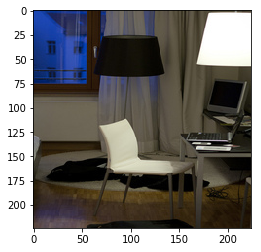

In [8]:
STRING='%012d' % image_id_key[0][0]
exp_image=ndimage.imread(TRAIN_IMAGE_PATH+'COCO_train2014_'+STRING+'.jpg')
plt.imshow(exp_image)
print('image_id ',image_id_key[:5])
print('the captions for this image ')
print(caption_to_id[:5])

이제 이미지 ID, feature vector들, 그리고 자막을 정렬했으므로 RNN에서 다음 단어 예측하기를 수행했을 때와 같이, 학습을 위한 자막들을 구성하겠습니다.

### 자막 인코딩 하기와 사전(dictionary)에 제한 설정하기

One-hot encoding을 사용할 때 각 단어의 vector 길이는 사전에 있는 단어 수와 동일합니다. 데이터의 모양에 대해 알아보려면 아래의 셀을 실행해 보십시오.

In [9]:
num_steps=20
######################################################################
##Create a list of all of the sentences.
DatasetWordList=[]
for dataset_caption in caption_to_id:
        DatasetWordList+=str(dataset_caption).split()
#Determine number of distinct words 
distinctwords=collections.Counter(DatasetWordList)
#Order words 
count_pairs = sorted(distinctwords.items(), key=lambda x: (-x[1], x[0])) #ascending order
words, occurence = list(zip(*count_pairs))
#DictionaryLength=occurence.index(4) #index for words that occur 4 times or less
words=['PAD','UNK','EOS']+list(words)#[:DictionaryLength])
word_to_id=dict(zip(words, range(len(words))))
#####################  Tokenize Sentence #######################
Tokenized=[]
for full_words in caption_to_id:
        EmbeddedSentence=[word_to_id[word] for word in full_words.split() if word in word_to_id]+[word_to_id['EOS']]
        #Pad sentences that are shorter than the number of steps 
        if len(EmbeddedSentence)<num_steps:
            b=[word_to_id['PAD']]*num_steps
            b[:len(EmbeddedSentence)]=EmbeddedSentence
        if len(EmbeddedSentence)>num_steps:
            b=EmbeddedSentence[:num_steps]
        if len(b)==EmbeddedSentence:
            b=EmeddedSentence
        #b=[word_to_id['UNK'] if x>=DictionaryLength else x for x in b] #turn all words used 4 times or less to 'UNK'
        #print(b)
        Tokenized+=[b]
        
print("Number of words in this dictionary ", len(words))

Number of words in this dictionary  4644


In [10]:
#Tokenized Sentences
Tokenized[::2000]

[[3, 180, 1030, 4, 17, 3, 334, 8, 3, 156, 9, 166, 2, 0, 0, 0, 0, 0, 0, 0],
 [3, 46, 5, 254, 771, 12, 7, 833, 45, 7, 501, 2, 0, 0, 0, 0, 0, 0, 0, 0],
 [162, 243, 44, 79, 385, 5, 161, 431, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [3, 164, 5, 19, 18, 16, 117, 3, 499, 114, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [79, 116, 6, 97, 1184, 6, 7, 1253, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [3, 56, 168, 65, 45, 602, 184, 8, 3, 2231, 52, 2, 0, 0, 0, 0, 0, 0, 0, 0]]

다음 셀은 데이터를 넣고 RNN 모델을 만드는 함수를 포함합니다. 각 함수의 출력(output)은 무엇일까요? 힌트가 필요한 경우 [여기](#정답2 "data_queue function은 data를 한 데 묶어주는 데, 이는 tokenized_caption, input_feature_map을 function의 return으로 갖는다. RNN model function은 prediction 정보를 return해야하며, 이는 softmax 이전에 pred value로 return 된다.")에 마우스를 올리세요.

```
(#정답2 "data_queue function은 data를 한 데 묶어주는 데, 이는 tokenized_caption, input_feature_map을 function의 return으로 갖는다. RNN model function은 prediction 정보를 return해야하며, 이는 softmax 이전에 pred value로 return 된다.")
```

In [13]:
def data_queue(caption_input,feature_vector,batch_size,):


    train_input_queue = tf.train.slice_input_producer(
                    [caption_input, np.asarray(feature_vector)],num_epochs=10000,
                                    shuffle=True) #False before

    ##Set our train data and label input shape for the queue

    TrainingInputs=train_input_queue[0]
    FeatureVectors=train_input_queue[1]
    TrainingInputs.set_shape([num_steps])
    FeatureVectors.set_shape([len(feature_vector[0])]) #fc7 is 4096
    min_after_dequeue=1000000
    capacity = min_after_dequeue + 3 * batch_size 
    #input_x, target_y
    tokenized_caption, input_feature_map = tf.train.batch([TrainingInputs, FeatureVectors],
                                                 batch_size=batch_size,
                                                 capacity=capacity,
                                                 num_threads=6)
#     return ##FIXME##,##FIXME##
    return tokenized_caption, input_feature_map
    
    

def rnn_model(Xconcat,input_keep_prob,output_keep_prob,num_layers,num_hidden):
#Create a multilayer RNN
#reuse=False for training but reuse=True for sharing
    layer_cell=[]
    for _ in range(num_layers):
        lstm_cell = tf.contrib.rnn.LSTMCell(num_units=num_hidden, state_is_tuple=True)
        lstm_cell = tf.contrib.rnn.DropoutWrapper(lstm_cell,
                                          input_keep_prob=input_keep_prob,
                                          output_keep_prob=output_keep_prob)
        layer_cell.append(lstm_cell)

    cell = tf.contrib.rnn.MultiRNNCell(layer_cell, state_is_tuple=True)
    outputs, last_states = tf.contrib.rnn.static_rnn(
        cell=cell,
        dtype=tf.float32,
        inputs=tf.unstack(Xconcat))

    output_reshape=tf.reshape(outputs, [batch_size*(num_steps),num_hidden]) #[12==batch_size*num_steps,num_hidden==12]
    pred=tf.matmul(output_reshape, variables_dict["weights_mscoco"]) +variables_dict["biases_mscoco"]
#     return ##FIXME##
    return pred

이제 [1], [2] 및 [3]에서 언급된 방법을 사용하여 RNN 학습을 시작하겠습니다. 여기서 현재의 caption과 이미지의 feature vector를 병합시켜 RNN에 넣어줄 것 입니다. 더 깊이 파고들어 실습 해도 얼마든지 괜찮습니다!  

In [14]:
tf.reset_default_graph()
#######################################################################################################
# Parameters
num_hidden=2048
num_steps=num_steps
dict_length=len(words)
batch_size=4
num_layers=2
train_lr=0.00001
#######################################################################################################
TrainingInputs=Tokenized
FeatureVectors=feature_maps_to_id

## Variables ## 
# Learning rate placeholder
lr = tf.placeholder(tf.float32, shape=[])
#tf.get_variable_scope().reuse_variables()

variables_dict = {
    "weights_mscoco":tf.Variable(tf.truncated_normal([num_hidden,dict_length],
                                                     stddev=1.0,dtype=tf.float32),name="weights_mscoco"),
    "biases_mscoco": tf.Variable(tf.truncated_normal([dict_length],
                                                     stddev=1.0,dtype=tf.float32), name="biases_mscoco")}


tokenized_caption, input_feature_map=data_queue(TrainingInputs,FeatureVectors,batch_size)
mscoco_dict=words

TrainInput=tf.constant(word_to_id['PAD'],shape=[batch_size,1],dtype=tf.int32)
#Pad the beginning of our caption. The first step now only has the image feature vector. Drop the last time step 
#to timesteps to 20
TrainInput=tf.concat([tf.constant(word_to_id['PAD'],shape=[batch_size,1],dtype=tf.int32),
                      tokenized_caption],1)[:,:-1]
X_one_hot=tf.nn.embedding_lookup(np.identity(dict_length), TrainInput) #[batch,num_steps,dictionary_length][2,6,7]
#ImageFeatureTensor=input_feature_map
# 4096개의 패딩을붙여줌
Xconcat=tf.concat([input_feature_map+tf.zeros([num_steps,batch_size,4096]), 
                     tf.unstack(tf.to_float(X_one_hot),num_steps,1)],2)#[:num_steps,:,:]

pred=rnn_model(Xconcat,1.0,1.0,num_layers,num_hidden)


#the full caption is the target sentence
y_one_hot=tf.unstack(tf.nn.embedding_lookup(np.identity(dict_length), tokenized_caption),num_steps,1) #[batch,num_steps,dictionary_length][2,6,7]

y_target_reshape=tf.reshape(y_one_hot,[batch_size*num_steps,dict_length])
#target = GT

# Define loss and optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=y_target_reshape))

optimizer = tf.train.MomentumOptimizer(lr,0.9)

gvs = optimizer.compute_gradients(cost,aggregation_method = tf.AggregationMethod.EXPERIMENTAL_TREE)
capped_gvs = [(tf.clip_by_value(grad, -10., 10.), var) for grad, var in gvs]
train_op=optimizer.apply_gradients(capped_gvs)

saver = tf.train.Saver()

init_op = tf.group(tf.global_variables_initializer(),tf.local_variables_initializer())    

with tf.Session() as sess:
        
    sess.run(init_op)
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(coord=coord)
    #Load a pretrained network
    saver.restore(sess, '/dli/data/mdt/mscoco/rnn_layermodel_iter40000')
    print('Model restored from file')
    
    for i in range(100):
        
        loss,y_pred,target_caption,_=sess.run([cost,pred,tokenized_caption,train_op],feed_dict={lr:train_lr})

        if i% 10==0:
            print("iteration: ",i, "loss: ",loss)
            
    MODEL_NAME='/dli/data/mdt/mscoco/rnn_model_iter'+str(i)
    saver.save(sess, MODEL_NAME) 
    print('saved trained network ',MODEL_NAME)
    print("Done Training")
    coord.request_stop()
    coord.join(threads)
    sess.close() 


INFO:tensorflow:Restoring parameters from /dli/data/mdt/mscoco/rnn_layermodel_iter40000
Model restored from file
iteration:  0 loss:  1.058342
iteration:  10 loss:  0.69718224
iteration:  20 loss:  0.59636617
iteration:  30 loss:  0.85211736
iteration:  40 loss:  1.1107126
iteration:  50 loss:  0.99170107
iteration:  60 loss:  0.54492795
iteration:  70 loss:  0.7364055
iteration:  80 loss:  0.79064685
iteration:  90 loss:  0.520984
saved trained network  /dli/data/mdt/mscoco/rnn_model_iter99
Done Training


인쇄문을 추가하여 RNN에 대한 입력 크기를 확인해 보십시오. Feature vector와 자막을 병합한 후의 RNN의 입력 형태는 무엇입니까? 힌트를 원한다면 [여기](#print "print(Xconcat.shape)")에 마우스를 올리세요.

우리는 TensorFlow에 loss를 측정하기 위해 네트워크 마지막 레이어의 '교차 엔트로피('cross-entropy with logits)’를 활용했습니다. 이 loss 측정은 네트워크의 학습 및 다른 솔루션들과 성능 비교하는 데 도움이 되는 것이지만, 여러분들은 아마도 만족스러운 예측기법에 대해 우리가 알고 있는 것보다 현재 솔루션이 얼마나 잘 작동하는지를 더 알고 싶을 것입니다.

Batch들이 포함된 배열의 index를 사용하여 마지막 batch의 단일 이미지와 자막을 평가하기 위해 아래 함수를 사용할 수 있습니다. 힌트가 필요한 경우 [여기](#정답3 "만약 batch_size가 4이면, batch_id는 0~3 사이의 값을 갖는다.")에 마우스를 올리세요.

##### 참조: 저장된 시점의 신경망 상태에 따라 불완전하고 일관성이 없으며 때로는 부적절한 자막이 생성될 수 있습니다.

Caption
['a', 'woman', 'hands', 'food', 'to', 'a', 'man', 'in', 'some', 'sort', 'of', 'natural', 'fiber', 'material', 'structure', 'EOS', 'PAD', 'PAD', 'PAD', 'PAD']
Predicted Words
['a', 'woman', 'standing', 'a', 'standing', 'a', 'boy', 'in', 'a', 'other', 'EOS', 'natural', 'EOS', 'EOS', 'EOS', 'EOS', 'PAD', 'PAD', 'PAD', 'PAD']


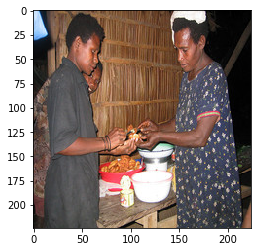

In [16]:
def show_next_predicted_word(batch_id,batch_size,id_of_image,target_caption,predicted_caption,words,PATH):
        Target=[words[ind] for ind in target_caption[batch_id]]
        Prediction_Tokenized=np.argmax(predicted_caption[batch_id::batch_size],1)
        Prediction=[words[ind] for ind in Prediction_Tokenized]
        STRING2='%012d' % id_of_image
        img=ndimage.imread(PATH+STRING2+'.jpg')
        return Target,Prediction,img,STRING2

#You can change the batch id to a number between [0 , batch_size-1]
# batch_id=##FIXME##
batch_id=3
image_id_for_predicted_caption=[x for x in range(len(Tokenized)) if target_caption[batch_id].tolist()== Tokenized[x]][0]


t,p,input_img,string_out=show_next_predicted_word(batch_id,batch_size,image_id_key[image_id_for_predicted_caption][0]
                                         ,target_caption,y_pred,words,TRAIN_IMAGE_PATH+'COCO_train2014_')
print('Caption')
print(t)
print('Predicted Words')
print(p)
plt.imshow(input_img)


지금까지 이것은 "다음 단어" 예측 변수이며, 이미지가 컨텍스트로 추가됩니다. 여러분은 이것이 도움이 될 한 시나리오가 떠오르나요? 만약 그렇다면, 잘하신 겁니다. 하지만, 다음과 같은 문제는 아직 해결되지 않았습니다.

**장면에 대한 설명구를 생성할 수 있나요?**

저장된 네트워크를 로드하여 검증용 이미지 하나에서 자막을 생성해 봅시다.

검증 이미지는 `/dli/data/mdt/mscoco/val2014`에 저장됩니다. Feature vector의 numpy 파일은 `/dli/data/mdt/mscoco/val_vgg_16_fc7_100.npy`에 저장됩니다. 아래의 ** ```##FIXME##```** 를 `/dli/data/mdt/mscoco/val_vgg_16_fc7_100.npy`로 대체하여 np.load 함수를 사용하여 추가하십시오.


In [19]:
##Load and test our test set
val_load=np.load('/dli/data/mdt/mscoco/val_vgg_16_fc7_100.npy').tolist()
val_ids=val_load.keys()

#Create 3 lists image_id, feature maps, and captions.
val_id_key=[]
val_map_to_id=[]
val_caption_to_id=[]
for observed_image in val_ids:   
    val_id_key.append([observed_image])
    val_map_to_id.append(val_load[observed_image])
    
print('number of images ',len(val_ids))
print('number of captions ',len(val_map_to_id))

number of images  100
number of captions  100


아래 내용은 검증 데이터셋의 이미지들 중 **오직 하나**에서 feature vector만 로드하고 이미 학습된 네트워크에서 자막을 생성할 것입니다. VALDATA 변수를 사용하여 RNN에 이미지를 전달하여 자막을 생성하십시오. 또한 saver.restore의 ** ```##FIXME##```** 에 파일 경로 `/dli/data/mdt/mscoco/rnn_model_iter99`를 삽입하여 네트워크를 다시 로드 하십시오. 힌트가 필요하시면 [여기](#정답5 "Validation set의 어떠한 data points라도 사용이 가능합니다. 501개의 caption들이 있고, VALDATA parameter로 0~99까지의 값을 사용할 수 있습니다. eg. VALDATA=10.")에 마우스를 올리세요.

##### 참조: 저장된 시점의 신경망 상태에 따라 불완전하고 일관성이 없으며 때로는 부적절한 자막이 생성될 수 있습니다.

```
#정답5 "Validation set의 어떠한 data points라도 사용이 가능합니다. 501개의 caption들이 있고, VALDATA parameter로 0~99까지의 값을 사용할 수 있습니다. eg. VALDATA=10.")
```

INFO:tensorflow:Restoring parameters from /dli/data/mdt/mscoco/rnn_model_iter99
Model restored from file
predicted sentence:  ['a', 'man', 'of', 'a', 'picture', 'of', 'a', 'phone', 'EOS', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD']


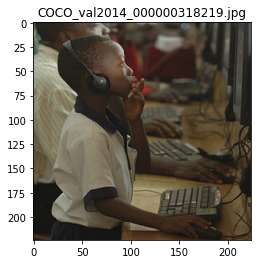

In [22]:
tf.reset_default_graph()
batch_size=1
num_steps=20
print_topn=0 #0for do not display 
printnum0f=3
#Choose a image to caption
# VALDATA=##FIXME##  #ValImage fc7 feature vector
VALDATA=10

variables_dict = {
    "weights_mscoco":tf.Variable(tf.truncated_normal([num_hidden,dict_length],
                                                     stddev=1.0,dtype=tf.float32),name="weights_mscoco"),
    "biases_mscoco": tf.Variable(tf.truncated_normal([dict_length],
                                                     stddev=1.0,dtype=tf.float32), name="biases_mscoco")}


StartCaption=np.zeros([batch_size,num_steps],dtype=np.int32).tolist()

CaptionPlaceHolder = tf.placeholder(dtype=tf.int32, shape=(batch_size , num_steps))

ValFeatureMap=val_map_to_id[VALDATA]
X_one_hot=tf.nn.embedding_lookup(np.identity(dict_length), CaptionPlaceHolder) #[batch,num_steps,dictionary_length][2,6,7]
    #ImageFeatureTensor=input_feature_map
Xconcat=tf.concat([ValFeatureMap+tf.zeros([num_steps,batch_size,4096]), 
                            tf.unstack(tf.to_float(X_one_hot),num_steps,1)],2)#[:num_steps,:,:]

pred=rnn_model(Xconcat,1.0,1.0,num_layers,num_hidden)
pred=tf.nn.softmax(pred)
saver = tf.train.Saver()

init_op = tf.group(tf.global_variables_initializer(),tf.local_variables_initializer())    

with tf.Session() as sess:
        
    sess.run(init_op)
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(coord=coord)
    #Load a pretrained network
#     saver.restore(sess, '##FIXME##')
    saver.restore(sess,'/dli/data/mdt/mscoco/rnn_model_iter99')
    print('Model restored from file')
    for i in range(num_steps-1):
        predict_next_word=sess.run([pred],feed_dict={CaptionPlaceHolder:StartCaption})
        INDEX=np.argmax(predict_next_word[0][i])
        StartCaption[0][i+1]=INDEX
        ##Post N most probable next words at each step
        if print_topn !=0:
            print("Top ",str(printnum0f), "predictions for the", str(i+1), "word in the predicted caption" )
            result_args = np.argsort(predict_next_word[0][i])[-printnum0f:][::-1]
            NextWord=[words[x] for x in result_args]
            print(NextWord)
        
    coord.request_stop()
    coord.join(threads)
    sess.close() 

STRING2='%012d' % val_id_key[VALDATA][0]
img=ndimage.imread('/dli/data/mdt/mscoco/val2014/COCO_val2014_'+STRING2+'.jpg')
plt.imshow(img)
plt.title('COCO_val2014_'+STRING2+'.jpg')
PredictedCaption=[words[x] for x in StartCaption[0]]
print("predicted sentence: ",PredictedCaption[1:])

어떤 이미지를 선택하느냐에 따라 결과가 달라질 수 있습니다. 더 많은 학습 및 더 다양한 데이터셋, 더 나은 데이터 네트워크 등 다양한 결과 개선 방법이 있지만, 이 워크플로우를 이해하고 다른 과제인 ‘비디오 자막 생성방법’을 실습하기 위해 이번 실습을 종료하고자 합니다.

앞으로 차이점을 소개하겠지만, 많은 워크플로우들이 동일하기 때문에 여러분들은 이 jupyter notebook에서 이미 배운 순환 신경망 (Recurrent Neural Networks)을 모델로 사용하여 이러한 *workflow*를 다시 만들게 될 것입니다. 메모리에 공간을 확보하려면 아래의 내용을 실행하십시오. 그러면 *Dead Kernel error*가 발생할 것 입니다.

In [ ]:
#Free our GPU memory before proceeding to the next part of the lab
import os
os._exit(00)

그런 다음, [비디오 자막 챌린지](../../task-assessment/task/VideoCaptioning-kr.ipynb)를 열어보십시오.

<a href="https://www.nvidia.com/dli"> <img src="images/DLI Header.png" alt="Header" style="width: 400px;"/> </a>

## References 

[1] Donahue, J, et al. "Long-term recurrent convolutional networks for visual recognition and description."     Proceedings of the IEEE conference on computer vision and pattern recognition. 2015.

[2]Vinyals, Oriol, et al. "Show and tell: Lessons learned from the 2015 mscoco image captioning challenge." IEEE transactions on pattern analysis and machine intelligence 39.4 (2017): 652-663.

[3] TensorFlow Show and Tell:A Neural Image Caption Generator [example](https://github.com/tensorflow/models/tree/master/research/im2txt)

[4] Karapthy, A. [NeuralTalk2](https://github.com/karpathy/neuraltalk2)

[5]Lin, Tsung-Yi, et al. "Microsoft coco: Common objects in context." European Conference on Computer Vision. Springer International Publishing, 2014.